# Demonstration of SMPS Calculations

In [136]:
from atmPy.instruments.DMA import smps
from atmPy.instruments.DMA import dma
from matplotlib import colors
import matplotlib.pyplot as plt
from numpy import meshgrid
import numpy as np
import pandas as pd
from matplotlib.dates import date2num
from matplotlib import dates
from atmPy import sizedistribution as sd
%matplotlib inline

done


In [2]:
hagis = smps.SMPS(dma.NoaaWide(),scan_folder="C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans")

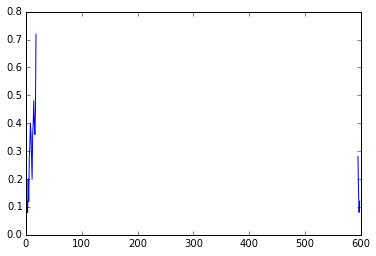

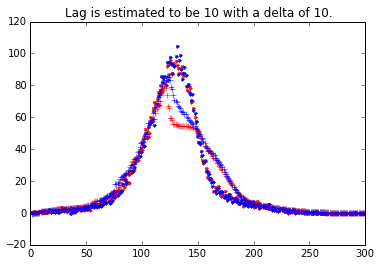

In [127]:
hagis.getLag(0, delta=10)

##Charge Correction 

In any charge correction, we must assume that there are no particles beyond the topmost bin.  This allows us to make the assumption that all particles in that bin are singly charged.  To determine all particles that belong in that bin that are of diameter $D_p$ with multiple charges, we can base this off of the predicted fraction of singly charged particles to multiply charged particles.  By using the following

\begin{equation}
\frac{N_i(D_p,i)}{f_i}=N(D_p)
\end{equation}

where $N_i$ is the number of particles of size $D_p$ having $i$ charges, $f_i$ is the charging efficiency for $i$ particles and $N(D_p)$ is the total number of particles expected having diameter $D_p$.  Since we assume that all particles in the current bin are singly charged, we can determine the expected number of particles of size $D_p$ with number of charges $i$ by using the following equation

\begin{equation}
N_i(D_p) = \frac{f_1}{f_i}N_1
\end{equation}

Finally, to get the total number of particles in the bin, we can apply the sum

\begin{equation}
N(D_p) = f_1N_1(D_p)\sum_{i=0}^\inf{f^{-1}_i}
\end{equation}

However, in each of these cases, only a finite number of particles may be available in each bin, so in the code, we will have to take the minimum of the following:

\begin{equation}
\delta{N(k)}=\min{\left(\frac{f_1N_1}{f_i},N_k\right)}
\end{equation}

where $\delta{N(k)}$ is the number of particles to remove from bin $k$ and $N_k$ is the number of particles in bin $k$.

In [4]:
hagis.proc_files()

C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_16_02_49.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_16_13_20.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_16_23_50.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_16_34_20.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_16_44_50.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_16_55_20.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_17_05_51.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_17_16_21.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_17_26_51.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_17_37_21.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_17_47_51.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_17_58_22.txt
C:/Users/mrichardson/Documents/HAGIS/SMPS/Scans/SCAN_20150315_18_08_52.txt
C:/Users/mrichardson/Docu

In [97]:
xfmt = dates.DateFormatter('%m/%d %H:%M')
xi = date2num(hagis.date)
XI, YI = meshgrid(xi, hagis.diam_interp)
#XI = dates.datetime.datetime.fromtimestamp(XI)
Z = hagis.dn_interp.transpose()
Z[np.where(Z <= 0)] = np.nan

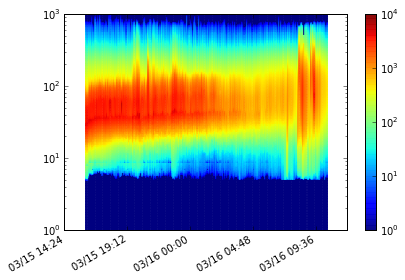

In [135]:
pmax = 10**np.ceil(np.log10(np.amax(Z[np.where(Z > 0)])))
pmin = 1#10**np.floor(np.log10(np.amin(Z[np.where(Z > 0)])))
fig, ax = plt.subplots()
pc = ax.pcolor(XI, YI, Z, cmap=plt.cm.jet, norm=colors.LogNorm(pmin, pmax, clip=False), alpha=0.8)

plt.colorbar(pc)
plt.yscale('log')
plt.ylim(1, 1000)
ax.xaxis.set_major_formatter(xfmt)
fig.autofmt_xdate()
fig.tight_layout()

Now, use the aerosol size distribution class to do some conversions.  First, we need get the data into a PANDAS dataframe.

In [170]:
dataframe = pd.DataFrame(hagis.dn_interp)
dataframe.index = hagis.date

In [209]:
from imp import reload
reload(sd)

<module 'atmPy.sizedistribution' from 'C:\\Users\\mrichardson\\Documents\\PythonScripts\\atm_py\\atmPy\\sizedistribution.py'>

In [210]:
binedges = (hagis.diam_interp[1:]+hagis.diam_interp[:-1])/2

first = hagis.diam_interp[0] -(binedges[0]-hagis.diam_interp[0])
last = hagis.diam_interp[-1]+ (hagis.diam_interp[-1]-binedges[-1])
binedges = np.append([first],binedges)
binedges=np.append(binedges,[last])
sizeDistr = sd.SizeDist_TS(dataframe,binedges, 'dNdlogDp')

(5, 1000)

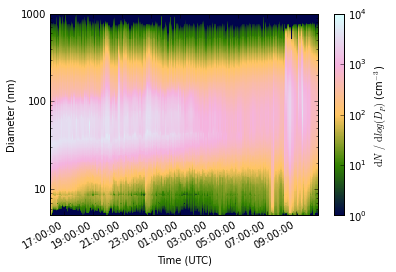

In [211]:
f,a,b,c = sizeDistr.plot(vmax = pmax, vmin = pmin, norm='log', showMinorTickLabels=False)
a.set_ylim((5,1000))

In [212]:
sfSD = sizeDistr.convert2dSdlogDp()

(5, 1000)

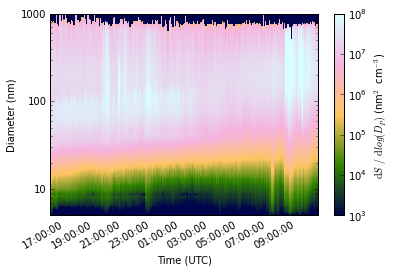

In [213]:
f,a,b,c = sfSD.plot(vmax = 1e8, vmin = 1e3, norm='log', showMinorTickLabels=False,removeTickLabels=['200','300','400',])
a.set_ylim((5,1000))

In [214]:
avgAt = sizeDistr.average_overAllTime()

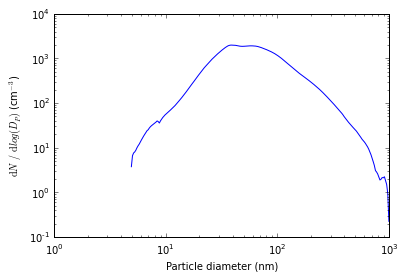

In [216]:
f,a = avgAt.plot(norm='log')
# a.set_yscale('log')

In [191]:
avgAtS = sfSD.average_overAllTime()

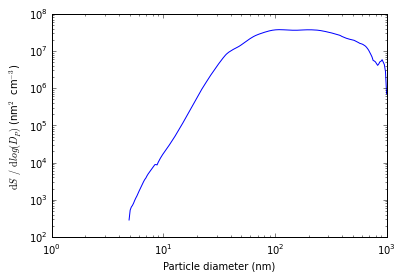

In [207]:
f,a= avgAtS.plot(norm='log')
a.set_yscale('log')

In [208]:
avgAt